In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()


Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=981809518 seed_offset=0 real_seed=981809518
core.init.random: RandomGenerator:i

In [2]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *
from recces.data import *
from recces.util import *
from rosetta.protocols.rna import *

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [4]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        if seq2 and ii == (n_residues/2) - 1: continue
            
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})

        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [5]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'linmin_iterated', 1e-6, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [6]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64.11)
        pose.set_torsion(dof_dict[6*ii+1], 176.33)
        pose.set_torsion(dof_dict[6*ii+2], 53.08)
        pose.set_torsion(dof_dict[6*ii+3], -150.17)
        pose.set_torsion(dof_dict[6*ii+4], -71.45)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79.43)
    
    return pose

In [7]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            if key > len(dofs)/2 -2: key += 5
            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
            
            if key > len(dofs)/2 - 2: key += 5 
            temp.set_torsion(dof_dict[key], val)
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result

In [413]:
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()

In [421]:
print rna_hires

rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
print scorefxn

ScoreFunction::show():
weights: (fa_atr 0.23) (fa_rep 0.12) (fa_intra_rep 0.0029) (lk_nonpolar 0.32) (fa_elec_rna_phos_phos 1.05) (ch_bond 0.42) (rna_torsion 0.1) (rna_sugar_close 0.7) (hbond_sr_bb_sc 0.62) (hbond_lr_bb_sc 3.4) (hbond_sc 3.4) (geom_sol 0.62) (atom_pair_constraint 1)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_RN

In [478]:
seq1 = 'guu'
seq2 = 'aac'

# Specify local path to where RECCES results are stored
try: 
    hist = SingleHistSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')
    norm = np.sum(hist._dos)
    print hist.value
except ValueError: pass

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)
#pose = pose_from_pdb('aaa_uuu_chainbreak.pdb')
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('/stepwise/rna/turner')
scorefxn = rna_hires
#scorefxn.set_weight(core.scoring.lk_nonpolar, 0)
#scorefxn.set_weight(core.scoring.stack_elec, 0)
minimum.assign(pose)

Inferring sequence from directory name:  guu_aac


IndexError: list index out of range

In [479]:
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'linmin_iterated', 1e-7, True)
minmover.max_iter(100000)
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)
#pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [480]:

import itertools

minimum = Pose()

pose.assign(helix_state(pose, dof_dict))
minmover.apply(pose)
minimum.assign(pose)
print scorefxn.show(pose)
h = 0.25
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(2/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-1, 1+h, h)
    
for pair in list(itertools.combinations(dof_dict.keys(), 2)):
    
    foo = pair[0]
    bar = pair[1]
    if foo > len(dofs)/2 - 2: foo -= 5
    if bar > len(dofs)/2 - 2: bar -= 5
    
    x = tor_ranges[:, foo]
    y = tor_ranges[:, bar]

    for ii, xx in enumerate(x):
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[bar])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[foo])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0:
        
        hessian[foo, foo] = d2E_dx2[ind, ind]
        
    if hessian[bar, bar] == 0:
        
        hessian[bar, bar] = d2E_dy2[ind, ind]
        
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
pose.assign(minimum)
try: scorefxn.show(ST_min)
except NameError: pass


core.scoring: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.730     -54.430     -39.734
 fa_rep                       0.100      47.929       4.793
 fa_intra_rep                 0.007      34.543       0.245
 lk_nonpolar                  0.250      -6.397      -1.599
 fa_elec_rna_phos_phos        4.540      -0.249      -1.132
 rna_torsion                  4.260       0.419       1.785
 stack_elec                   1.540      -3.538      -5.448
 hbond_sc                     2.460      -9.880     -24.304
---------------------------------------------------
 Total weighted score:                      -65.394
None


In [481]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)
print w,

[  5.08827199e-01   1.66772401e+00   2.64865175e+00   4.69768621e+00
   8.36833687e+00   1.00791930e+01   1.11913297e+01   1.63988520e+01
   2.00041045e+01   2.19895729e+01   3.12104459e+01   4.44636622e+01
   6.04933050e+01   7.12410580e+01   7.59804957e+01   1.15055341e+02
   2.18823804e+02   3.33825656e+02   4.29900481e+02   9.09856413e+02
   9.50084323e+02   1.31191312e+03   3.30992851e+03   4.84030030e+03
   9.69684714e+03   1.36609758e+04]


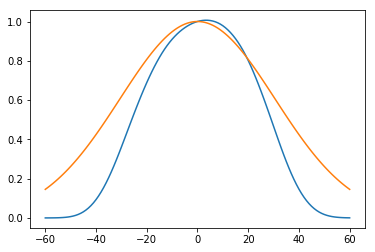

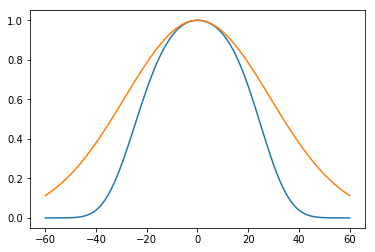

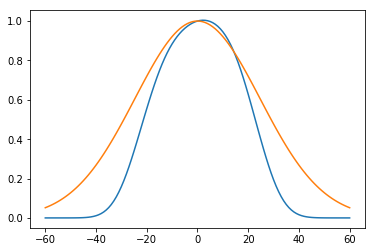

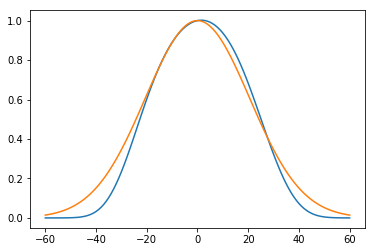

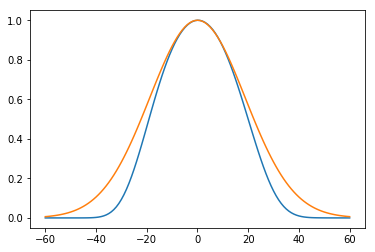

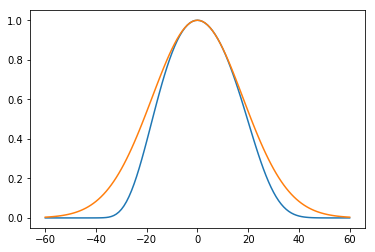

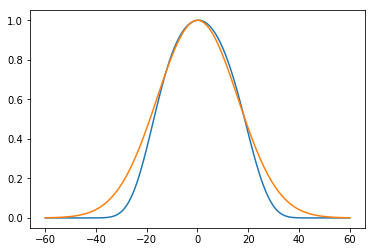

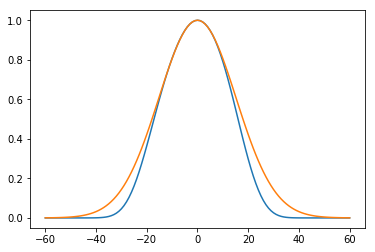

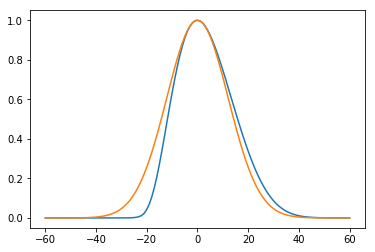

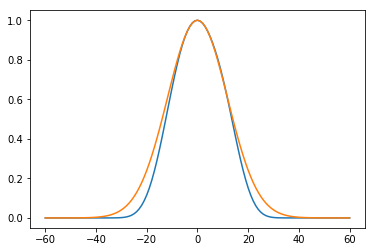

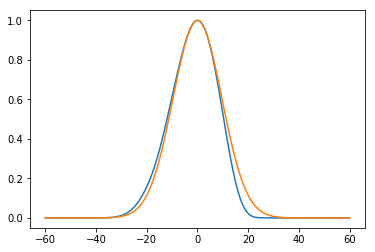

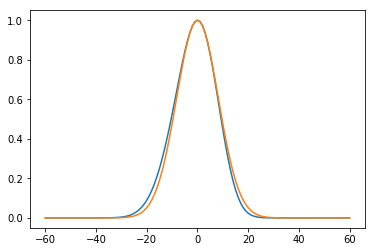

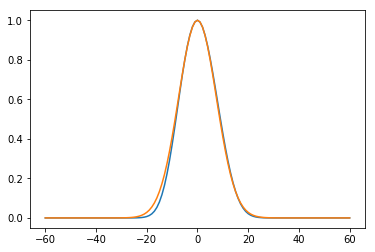

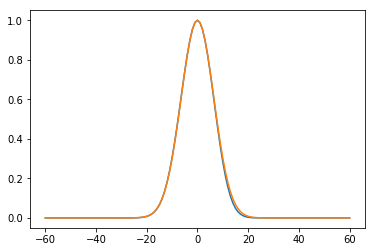

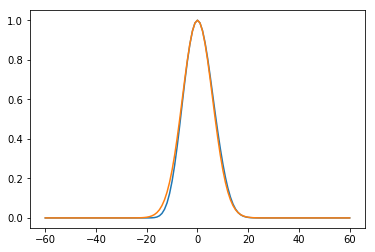

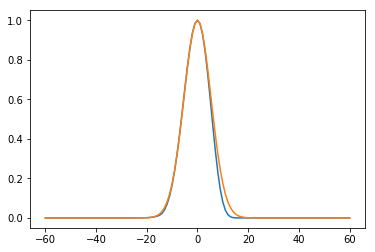

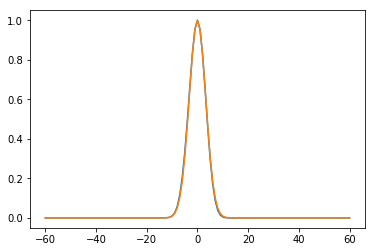

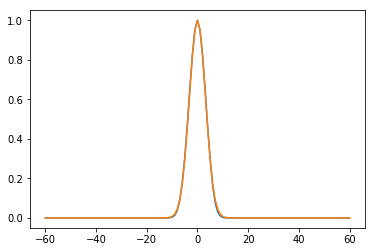

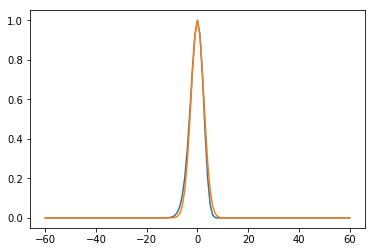

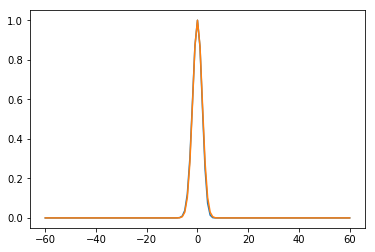

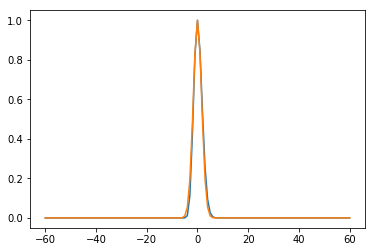

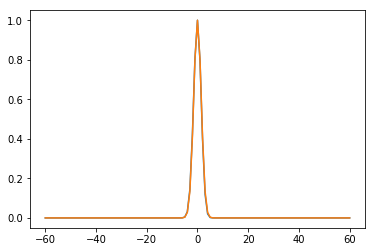

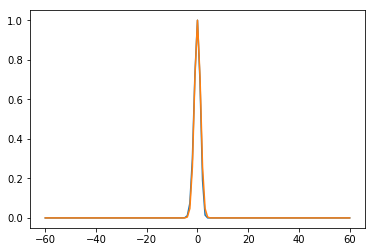

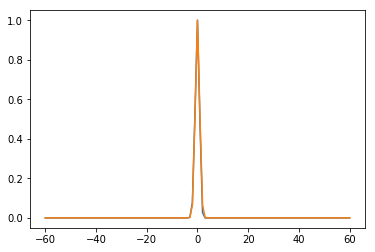

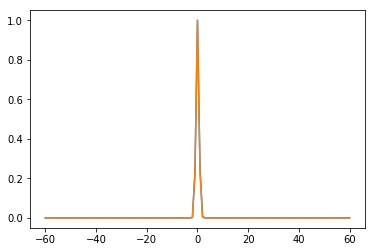

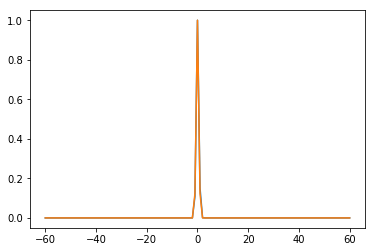

In [380]:
'''this code will assay the normal modes, plotting the corresponding boltzmann weights for both the harmonic approximation
and scanned modes'''

import scipy.integrate

pose.assign(minimum)
kT = 1.0

for kk, K in enumerate(w):
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            if jj > len(dofs)/2 - 2: jj += 5
            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)

    np.array(bar) 
    pose.assign(minimum)
    plt.figure()
    #plt.subplot(5, 3, kk+1)
    plt.plot(h, np.exp(-np.array(bar)))
   
    plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')

In [482]:
'''this code will calculate the configuration integral using both harmonic approximation and mode scanning'''

from scipy.special import *
pose.assign(minimum)
V = 1
kT = 1.0
Z_harm = 1.00
Z_scan = 1.00
Z = 1.00
for ii, K in enumerate(w):

    # Mode scanning
    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 1)
    
    sig = min(2*np.pi/3, 6*np.sqrt(kT/K))
    V*=sig
    # Harmonic approximation
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    
    if abs(np.log(Z_i/Z_j)<0.5): Z *= Z_i
    else: Z*=Z_j
    pose.assign(minimum)
    
    print Z_i, Z_j

1.91489505407 0.933977418313
1.59888438158 0.720259471029
1.4041573572 0.886119232841
1.12964613585 0.879343778662
0.864164187986 0.685922243175
0.787413691204 0.610444789207
0.747265611338 0.643674247727
0.617318252982 0.54037528677
0.558928537915 0.541160991399
0.533098480829 0.502591464117
0.447471989866 0.383930170247
0.374898089398 0.344728120816
0.321412072827 0.319668375651
0.296176544485 0.293108967658
0.286790512923 0.296955346754
0.233057160105 0.216659463957
0.168992939657 0.161525017436
0.136822016309 0.147390496782
0.120567949907 0.119929936496
0.082876120244 0.0787929584043
0.0811025979071 0.0854982169465
0.0690181485391 0.0634130141782
0.043451676297 0.0393686422624
0.0359318591477 0.0361658915953
0.0253863677629 0.0212556852029
0.0213882366269 0.0236222887831


In [483]:
print scorefxn(minimum) - np.log(Z_harm), scorefxn(minimum) - np.log(Z_scan), scorefxn(minimum) - np.log(Z)
print -0.5*np.log(scipy.linalg.det(hessian)) + np.log(torsion_volume(seq1, seq2))
print 0.5*np.log(Z_scan), 0.5*np.log(Z_harm)
sim = SingleSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/', curr_wt)
print sim.value, sim.avg_energy, sim.entropy

-30.2233954347 -26.6180112321 -28.7079797172
applying phase space volume for two strand with helix length  3  and dangle length  0
-38.8658273273
-19.3880730913 -17.58538099
Inferring sequence from directory name:  guu_aac
Created:  hist_list.txt


ValueError: 'axis' entry is out of bounds

In [436]:
def partition_function(kT):
    
    Z = 1
    for K in w:
        
        
        sig = np.pi/6
        Z *= math.sqrt(2.0*np.pi/K/kT)*erf(math.sqrt(2.0*kT*K)*sig/4.0)
        
    return Z/((2*np.pi/3)**len(w))

In [402]:
'this code defines an implementation of the Stehfest method for numerically calculating the inverse laplace transform'
import scipy.misc

fact = scipy.misc.factorial

def csteh(n, i):
    acc = 0.0
    for k in xrange(int(np.floor((i+1)/2.0)), int(min(i, n/2.0))+1):
        num = k**(n/2.0) * fact(2 * k)
        den = fact(i - k) * fact(k -1) * fact(k) * fact(2*k - i) * fact(n/2.0 - k)
        acc += (num /den)
    expo = i+n/2.0
    term = np.power(-1+0.0j,expo)
    res = term * acc
    return res.real

def nlinvsteh(t, F=partition_function, n = 18):
    acc = 0.0
    lton2 = np.log(2) / t
    for i in xrange(1, n+1):
        a = csteh(n, i)
        b = F(i * lton2)
        acc += (a * b)
        
    if lton2 * acc > 0.: return lton2 * acc
    else: return 0.

In [403]:
t = np.linspace(0,800,8001)
A = []
for tt in t: A.append(nlinvsteh(tt))
t = np.array(t)
A = np.array(A)
A[A<0.]=0.0


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


applying phase space volume for two strand with helix length  2  and dangle length  0


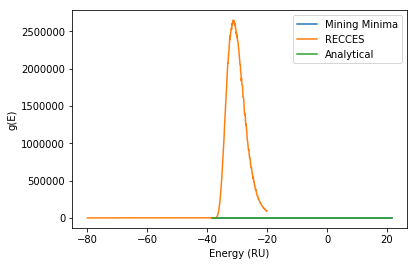

In [404]:
plt.plot(t[:600]+rna_hires(minimum), 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
#plt.plot(r+E_avg, 0.1*np.exp(g)*np.exp(-r))
plt.plot(hist._dos_scores[201:800], hist._dos[201:800]*np.exp(-hist._dos_scores[201:800]/1.0))
plt.plot(t[:600]+rna_hires(minimum), 0.105*matt_guess(E[1000:1600])*np.exp(-(E[1000:1600])/1.0)*(2*np.pi)**len(w))
plt.xlabel('Energy (RU)')
plt.ylabel('g(E)')
plt.legend(('Mining Minima', 'RECCES', 'Analytical'))

In [ ]:
bar = scipy.special.logsumexp(-(t+rna_hires(minimum)), b = A)
print bar
print scipy.special.logsumexp(-hist._dos_scores, b = hist._dos)

In [ ]:
plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000]+scorefxn(minimum))/1.0)*A[:1000]/np.exp(-scorefxn(minimum))*4e14)
plt.plot(hist._dos_scores[260:1200],hist._dos[260:1200]*np.exp(-(hist._dos_scores[260:1200]/1.0)))

In [ ]:

print t[100:] + scorefxn(minimum)

In [177]:
from recces.util import *
from recces.data import *
curr_wt = [0.73, 0.1, 0.0071, 0, 4.26, 2.46, 0.25, 0, 1.54, 4.54]

In [178]:
E = np.linspace(0,800,8001)
print t

NameError: name 't' is not defined

In [405]:
E_avg = rna_hires(minimum)
print E_avg

-38.3114946042


In [406]:
matt_guess = lambda E: 2*(2*np.pi)**((len(w)-1)/2)*(2*(E))**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))

applying phase space volume for two strand with helix length  2  and dangle length  0
applying phase space volume for two strand with helix length  2  and dangle length  0


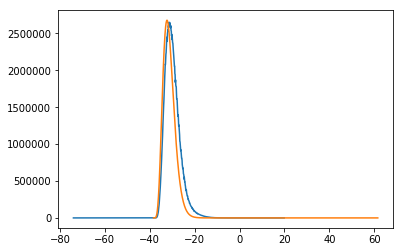

In [437]:
#plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000])/1.0)*A[:1000]*1e12)# numerical 
#plt.plot(t[:1000]+E_avg, harmonic_dos(t[:1000])*np.exp(-((t[:1000])/1.00))/torsion_volume(seq1,seq2)*5e17)# harmonic
plt.plot(hist._dos_scores[260:1200], hist._dos[260:1200]*np.exp(-hist._dos_scores[260:1200]/1.0)) # RECCES
norm = np.sum(hist._dos)*torsion_volume(seq1, seq2)
a = 0.0001/scipy.integrate.trapz(matt_guess(E))
plt.plot(E[:1000]+E_avg, 1.6e-1*(2*np.pi)**len(w)*torsion_volume(seq1, seq2)*matt_guess(E[:1000])*np.exp(-(E[:1000])/1.0))# Matt's guess for analytical

In [239]:
print hist._dos_scores
dos_scores = np.array(hist._dos_scores)
dos = np.array(hist._dos)
print -scipy.misc.logsumexp(-dos_scores,b=dos) - np.log(torsion_volume(seq1, seq2))
print hist.value - np.log(torsion_volume(seq1,seq2)), 

[-100.   -99.9  -99.8 ...,  799.8  799.9  800. ]
applying phase space volume for two strand with helix length  2  and dangle length  0
-32.5172279806
applying phase space volume for two strand with helix length  2  and dangle length  0
-32.5172279806


In [240]:
plt.plot(t[:1000]+E_avg, matt_guess(t[:1000])*np.exp(-(t[:1000])/1.0))

NameError: name 't' is not defined

In [243]:
bar = -scipy.special.logsumexp(-(E+E_avg), b=matt_guess(E))
print bar
print sim.value

-25.6233758059
-22.1680584134


In [207]:
plt.plot(t[:1000]+scorefxn(minimum), harmonic_dos(t[:1000]-E_avg)*np.exp(-(t[:1000]+scorefxn(minimum))))

NameError: name 't' is not defined

In [ ]:
print bar - np.log(torsion_volume(seq1, seq2))
print hist.value - np.log(torsion_volume(seq1, seq2))

In [ ]:
print pose.annotated_sequence()

In [ ]:
pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [ ]:
print pose.annotated_sequence()
print minimum.fold_tree()

In [ ]:
def wang_landau(K):
    '''Computes the density of states using the Wang-Landau algorithm (see, e.g., )'''
    
    #E = lambda x: 0.5*np.dot(K, x**2)
    
    E = mm_energy(pose, )
    dr = 0.005
    f = np.exp(1)
    r = np.arange(0,50,dr)
    g = np.zeros_like(r)
    H = np.zeros_like(r)
    x_0 = 0.05*np.ones_like(K)
    print E(x_0)
    
    while f > np.exp(1e-8):
    
        ii = 0
        print f
        while ii < 100000:

            x = np.random.uniform(0, 0.08, (len(K)))
            x_ind = int(E(x)/dr)
            x_0_ind = int(E(x_0)/dr)
            if x_ind > H.shape[0]-1: continue

            if np.log(g[x_ind]) < np.log(g[x_0_ind]) or np.exp(np.log(g[x_ind])-np.log(g[x_0_ind])) < np.random.uniform():


                H[x_ind] += 1
                g[x_ind] += f
                x_0 = x

            else: 

                H[x_0_ind] += 1
                g[x_0_ind] += f
                
            ii += 1

        if H.any < 0.95*np.average(H): continue 

        f = f**0.5
        H = np.zeros_like(r)

    return g, r

In [ ]:
g, r = wang_landau(w)
g = g/max(g)

In [ ]:
plt.plot(r, np.exp(g)*np.exp(-r))
print -np.log(scipy.special.logsumexp(-(r+scorefxn(minimum)), b=g)) - np.log(torsion_volume(seq1, seq2))

In [ ]:
plt.plot(r, np.exp(g))

In [ ]:
def mm_energy(pose, delta, dof_dict, sf):
    
    temp = Pose()
    temp.assign(pose)
            
    for key, val in enumerate(delta):

        if key > len(delta)/2 -2: key += 5
        temp.set_torsion(dof_dict[key], temp.torsion(dof_dict[key]) + val*180./np.pi)
        
    return sf(temp)

In [ ]:
norm = np.sum(hist._dos)

In [ ]:
print np.log(norm*torsion_volume(seq1, seq2))

In [ ]:
max(matt_guess(E[1000:2000])*np.exp(-E[1000:2000]))

In [ ]:
dr = 0.1
r = np.arange(-100,500+dr,dr)
g = np.zeros_like(r)
H = np.zeros_like(r)

f = np.exp(1)
sig = 1/np.sqrt(w)

delta_0 = np.zeros_like(w)
E_min = scorefxn(minimum)
E_0 = E_min

while np.log(f) > 1e-8:

    print f
    H[:] = 0
    ii = 0
    
    while ii < 10000:

        y = np.random.randint(0,len(w))
        delta = np.random.normal(0.0, 1.0/np.sqrt(w[y]))*v[:,y]

        #delta = np.random.uniform(-np.pi/3, np.pi/3, len(w))
        #y = np.random.randint(0,len(w))
        #delta = v[:,y]*np.random.uniform(-np.pi/3,np.pi/3)
        
        #E = E_min + 0.5*np.dot(w,delta**2)
        E = mm_energy(minimum, delta, dof_dict, scorefxn)
        #E = mm_energy(minimum, delta, dof_dict, scorefxn)

        ind = int((E+100)/dr)
        #ind_0 = int((E_0+100)/dr)

        if ind > len(r) -1: ind = -1
        H[ind] += 1
        ii += 1
        '''if np.random.uniform() < np.exp(g[ind_0]-g[ind]):
            
            g[ind] += 1#np.log(f)
            H[ind] += 1
            delta_0 = delta
            E_0 = E
            
        else:

            g[ind_0] += 1#np.log(f)
            H[ind_0] += 1
            
        ii += 1
           ''' 
    #if H.any() < 1: continue   
    f = np.sqrt(f)




In [ ]:
plt.plot(r[:2000], H[:2000]*np.exp(-r[:2000])/2e17)
print -scipy.special.logsumexp(-r, b=H/2e17) - np.log(torsion_volume(seq1, seq2))
plt.plot(t[:600]+E_min, 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
plt.plot(hist._dos_scores[260:1400], hist._dos[260:1400]*np.exp(-hist._dos_scores[260:1400]))
plt.xlabel('Energy (RU)')
plt.ylabel('g(E)')
plt.legend(('WL', 'InvLaplace', 'RECCES'))

In [ ]:
print scorefxn(minimum)

In [ ]:
print scorefxn(minimum) / 0.1

In [ ]:
np.set_printoptions(threshold='nan')

In [ ]:
print h

In [ ]:
print g

In [ ]:
print g

In [ ]:
plt.plot(t[:600]+rna_hires(minimum), 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
plt.plot(r[:-1], g[:-1]*np.exp(-r[:-1])/2e21)

In [ ]:
print H

In [ ]:
g1 = g

In [ ]:
g2 = g
fuck = np.convolve(g1, g2)
print fuck

In [ ]:
hist.value

In [ ]:
1/np.sqrt(scipy.linalg.det(hessian))

In [75]:
sim = SingleSimulation('./../recces_rosetta/results/ggg_ccc/ST/', curr_wt)

Inferring sequence from directory name:  ggg_ccc
Created:  hist_list.txt
applying phase space volume for two strand with helix length  3  and dangle length  0


In [78]:
print sim.entropy

-25.7071828714


In [50]:
print -scipy.special.logsumexp(-(hist._dos_scores + hist.value), b=hist._dos*hist._dos_scores)

nan


/usr/local/lib/python2.7/dist-packages/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


In [33]:
print hist.value

-22.1675210922


In [21]:
print hist._avg_energy

AttributeError: 'SingleHistSimulation' object has no attribute '_avg_energy'

In [24]:

print sim.value - sim._avg_energy


12.5802215046


In [ ]:
clear sim

In [110]:
hist = SingleHistSimulation('./../recces_rosetta/results/gg_cc/ST')

Inferring sequence from directory name:  gg_cc
applying phase space volume for two strand with helix length  2  and dangle length  0


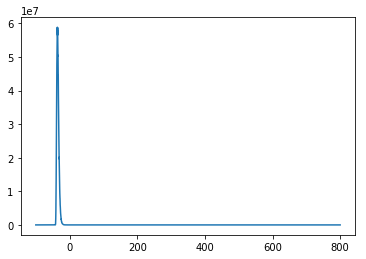

In [143]:
plt.plot(hist._dos_scores[:-1], hist._dos[:-1]*np.exp(-hist._dos_scores[:-1]))